# **Sentiment Analysis Using Gated-Recurrent Neural Networks**

In this assignment, we will use the IMDB dataset that contains the text of 50,000 movie reviews from the Internet Movie Database (IMDB) website. The label of each movie review is either positive or negative. An example of the input-output pair in this dataset is

"*I happen to run into this movie one night so I decided to watch it ! I was very pleased with the movie ... I thought it was a wonderful plot . It 's a great feeling knowing a deceased one has come back and you get that second chance to say what you want to say ! And this wife stayed devoted for 23 years ! ! ! I thought it was a great movie ! !*"

where its label, as you might expect, is 
"*positive*".

**In this assignment, we want to design a classifier that takes as input a review and outputs whether it is a positive or negative review about a movie.**

In the next two cells, we import some modules and also fix some constants for our implementation. 

In [ ]:
import csv
from typing import Callable, Tuple

import jax.numpy as jn
import matplotlib.pyplot as plt
import numpy as np
from jax import lax
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from tqdm import trange
from sklearn.model_selection import train_test_split
%pip --quiet install objax
import objax
from objax.typing import JaxArray
import pickle


objax.random.DEFAULT_GENERATOR.seed(42)
np.random.seed(42)

     |████████████████████████████████| 51kB 6.8MB/s 


In [ ]:
!gdown --id 11r58MB8wRBO1o1gEC-zxiADZIuwMnhf7

Downloading...
From: https://drive.google.com/uc?id=11r58MB8wRBO1o1gEC-zxiADZIuwMnhf7
To: /content/IMDB Dataset.csv
66.2MB [00:00, 108MB/s] 


In [ ]:
max_vocab = 2000  # this parameter is for the maximum number of words in the "dictionary"
max_len = 200  # maximum length of each review
embedding_size = 30  # size of embedding
num_hidden_units_GRU = 30  # GRU cells in the RNN layer
num_hidden_units = 60  # hidden unit of dense network after GRU

vocab_size = max_vocab
filename = 'IMDB Dataset.csv'

# How to find a representation of sentences?
In order to put the words into the machine learning algorithm the text data should be converted into a vector representation. The first approach that comes to mind is *one hot encoding*.
 # One Hot Encoding
Assume that we count the number of english words in the Merriam-Webster dictionary, and it turns out that the total number of words is $N$. Then, a possible way to represent the words is to use binary vectors of size $N$. Each integer value is represented as a binary vector that is all zero values except the index of the integer, which is marked with a $1$.
As an example let's say all the words in the dictionary consists of $\{$apple, orange, Milan,Rome$\}$. For this example, the one hot encoding is given by:
 
apple = $[1,0,0,0]$ \\
orange = $[0,1,0,0]$ \\
Milan = $[0,0,1,0]$  \\
Rome = $[0,0,0,1]$
 
We can also represent each word by an integer: for instance in the above-mentioned example, the mapping is apple $\rightarrow$ 1, orange $\rightarrow$ 2, Milan $\rightarrow$ 3,  Rome $\rightarrow$ 4.
 



When we are working with a dataset, a practical approach for one-hot encoding of the data is as follows:
 
1.  First, we can create a dictionary which shows each word along with its frequency in the dataset. For example, if the sentence is "Put the books on the table." , we need to create a dictionary such that word_index["Put"] = 1; word_index["the"] = 2; word_index["books"] = 1; word_index["on"] = 1; word_index["table"] = 1.
2.  Second, based on the maximum size of the vocabulary we want, we can sort the words based on their frequency and only pick the most frequent words of this maximum size of the vocabulary, and this creates our dictionary. So lower integer means more frequent word (often the first few are stop words because they appear a lot)
 
3. Then, we can assign an integer to each word in the dictionary, and represent each sentence as a sequence of integers.
 
 
The following function performs the above-mentioned steps for our IMDB dataset.



In [ ]:
def data_processing(filename, max_vocab, max_len):
  # filename: the name of the .csv file
  # max_vocab: The maximum number of words
  # max_len: 
  messages = []  # a list contains the reviews
  labels = []  # a list contains the labels
  with open(filename, 'r') as file:
      reader = csv.reader(file)
      firstline = True
      for row in reader:
        if firstline:
            firstline = False
            continue
        else:
            messages.append(row[0])
            labels.append(int(row[1]=='positive'))

  tokenizer = Tokenizer(num_words=max_vocab)
  tokenizer.fit_on_texts(messages)
  messages_seq = tokenizer.texts_to_sequences(messages)
  data = pad_sequences(messages_seq, maxlen=max_len)  
  train_size = 0.8
  messages_train, messages_valid_test, labels_train, labels_valid_test  = train_test_split(data, labels, train_size=train_size)
  messages_valid, messages_test, labels_valid, labels_test  = train_test_split(messages_valid_test, labels_valid_test, train_size=0.5)
  return np.array(messages_train), np.array(labels_train), np.array(messages_valid), np.array(labels_valid), np.array(messages_test), np.array(labels_test)

For the data_processing function, we used Tokenizer which is a class in keras.preprocessing.text. The following questions are about the different methods in this class. \\



**Question 1** [1 points]: In your own words, explain what does "fit_on_texts" do? \\

fit_on_texts updates internal vocabulary based on list of texts. When text contains list, it is assumed that each entry of the list as a token.[1] Here, vocabulary index based on the word frequency is created. The indexing starts from 1 and 0 is reserved for padding. Lower integer corresponding to a word implies high frequency of that word.[2] It is required before using text_to_sequences.

[1] https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer#texts_to_sequences

[2] https://stackoverflow.com/questions/51956000/what-does-keras-tokenizer-method-exactly-do


**Question 2** [1 points]: In your own words, explain what does "texts_to_sequences" do? \\

texts_to_sequences transforms each text to a sequence of integers. Top number_of_words - 1, most frequent words (words recognized by tokenizer) will be taken.[1] It succeeds fit_on_texts. It takes the word and replaces it with the corresponding index from the word dictionary[2] which we obtain after fitting the fit_on_texts. If the word is not there in the dictionary, then it is left blank/no index.

[1] https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer#texts_to_sequences

[2] https://stackoverflow.com/questions/51956000/what-does-keras-tokenizer-method-exactly-do


**Question 3** [1 points]: In your own words, explain what does "pad_sequences" do, and why do we need it? \\

pad_sequences pads the sequences to a same length. This function transforms a list of sequences into a 2D numpy array of shape (number_of_samples, maxlen if provided or the length of longest sequence). Sequences shorter than length of longest sequence are padded. Sequences longer than maxlen are truncated. The padding or truncation position is determined by the arguments padding and truncating, respectively.[3]

[3] https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences

In the next cell, we encode the data set using one-hot encoding, and split the dataset into the training set, validation set, and the test test.

In [ ]:
messages_train, labels_train, messages_valid, labels_valid, messages_test, labels_test = data_processing(filename, max_vocab, max_len)

**Question 4** [1 points]: Print one of the input in the training set and explain your observation? Does it match with what you expected?

The words in the first sequence are replaced with the index of its corresponding words in the word dictionary and the repeated index implies, that word is a stop word and appears quite frequently. From observation we can see that the index most repeated is lower indexes thus, the output matches correctly with my understanding.

In [ ]:
messages_train[0]

array([ 634,   12,  239,  110,  846,   36,  172,   30,  224,  196,    1,
        434,  365,   55,    3,  279,    7,    7,  157, 1726,  190,    6,
          1,  738, 1993,    1, 1180,    4, 1882,    2,  146,  145,    3,
        226,    4,    3,  207,  326,    2,  145, 1077,   16,   88,    4,
        132,   18,   10,  154,   99,    4,    1,  300,   11,   17,  989,
         36,    1,  495,  492,  250,   73,   76,  106,  106,  696,   60,
         85, 1057, 1343,    5,  229,  132,   23,   31,  138,  212, 1133,
         14,   31,    3,    2,    8,   11,    6,    3,  448,   14,  619,
          4,    1,  719,    1, 1245,    2,   73,    1,  164, 1514,    1,
       1239,    5, 1674,    1,  888, 1261,    5,    1,  309,  140,    2,
        410,  624,    7,    7,    1,  272,    6, 1010,    5,   26,   39,
         14, 1378,  217,   65,    2,   46,    6,   30,  224,   27,  191,
       1473,    8, 1088,   18,   10,   84,    1,  227,   66,  358,   68,
         54,   27,    5,   15,   44,   21,  193,   

# Embedding Layer



Imagine that we have 80,000 unique words in a text classification problem and we select to preprocess the text as explained above. For instance, a sentence "i love you" or ['i', 'love', 'you'] can be shown as a matrix of size (3 , 80000) where its elements is all zeros except from 3 elements that correspond to those words. In the case that we want to extract the feature using recurrent neural netowk, the input size should be the size of $80,000$ in which only three entries are non-zero!

Instead, we can use the observation that since our goal is to extract feature from a sentence, we might be able to construct a mapping so that the words whose meanings are similar map to the same vector. One possible approach to do this is to perform this maaping using a simple matrix multiplication that transforms words into their corresponding word embeddings or turns positive integers (indexes) into dense vectors of fixed size, where the size of embedding $\ll$ size of the vocabualry. 

Please watch this short video to gain better understanding of the embedding layer:


https://www.coursera.org/lecture/nlp-sequence-models/learning-word-embeddings-APM5s


Since Objax does not have embedding layer module in it, we need to write our own module. One implementaiton of the embedding layer is as follows. 

In [ ]:
class Embed(objax.Module):
    def __init__(self, size: int, latent: int, init: Callable = objax.nn.init.xavier_truncated_normal):
        self.w = objax.TrainVar(init((size, latent)))

    def __call__(self, x: JaxArray) -> JaxArray:
        return self.w.value[x]

**Question 5: [1 points]**  Briefly explain how `__init__` and `__call__` functions work when the input is a sentence?

__init__ is used to initialize a newly created object and it stores a training variable created using objax.nn.init.xavier_truncated_normal module which takes the input shape as max_len and embedding size. The module truncates the size of the sample to the desirable dimensions (here embedding size). __call__ is called when the instance is called and is used to return the tensor initialized with truncated normal random variable for the sequence provided.

# Gated Recurrent Unit Cell
GRUs are a family of the recurrent neural networks used for processing of the sequential data. In this assignment, we want to use GRU for the sentiment analysis.

The forward pass of a Gated Recurrent Unit is defined by the following equations:




1.   $z_t = \text{sigmoid} (W_z x_t + U_z h_{t-1} + b_z)$
2.   $r_t = \text{sigmoid} (W_r x_t + U_r h_{t-1} + b_r)$
3.   $\hat{h}_t = \text{tanh} (W_h x_t + U_h (r_t \odot h_{t-1}) + b_h)$
4.   $h_t =  (1-z_t)\odot h_{t-1} + z_t \odot \hat{h}_t$

where
the operator ${\displaystyle \odot }$  denotes the Hadamard product, and 

*  $x_{t}$: input vector
*   $h_{t}$: output vector
* ${\hat {h}}_{t}$: candidate activation vector
* $z_{t}$: update gate vector
* $r_{t}$: reset gate vector
* $W_z$, $W_r$, $W_h$ , $U_z$, $U_r$, $U_h$, $b_z$ ,$b_r$, $b_h$ are parameter matrices and vectors.







The schematic of a GRU cell is show below (taken from Wikipedia). Here $\hat{y}_t$ is the same as $h_t$, and $\sigma$ is sigmoid function.

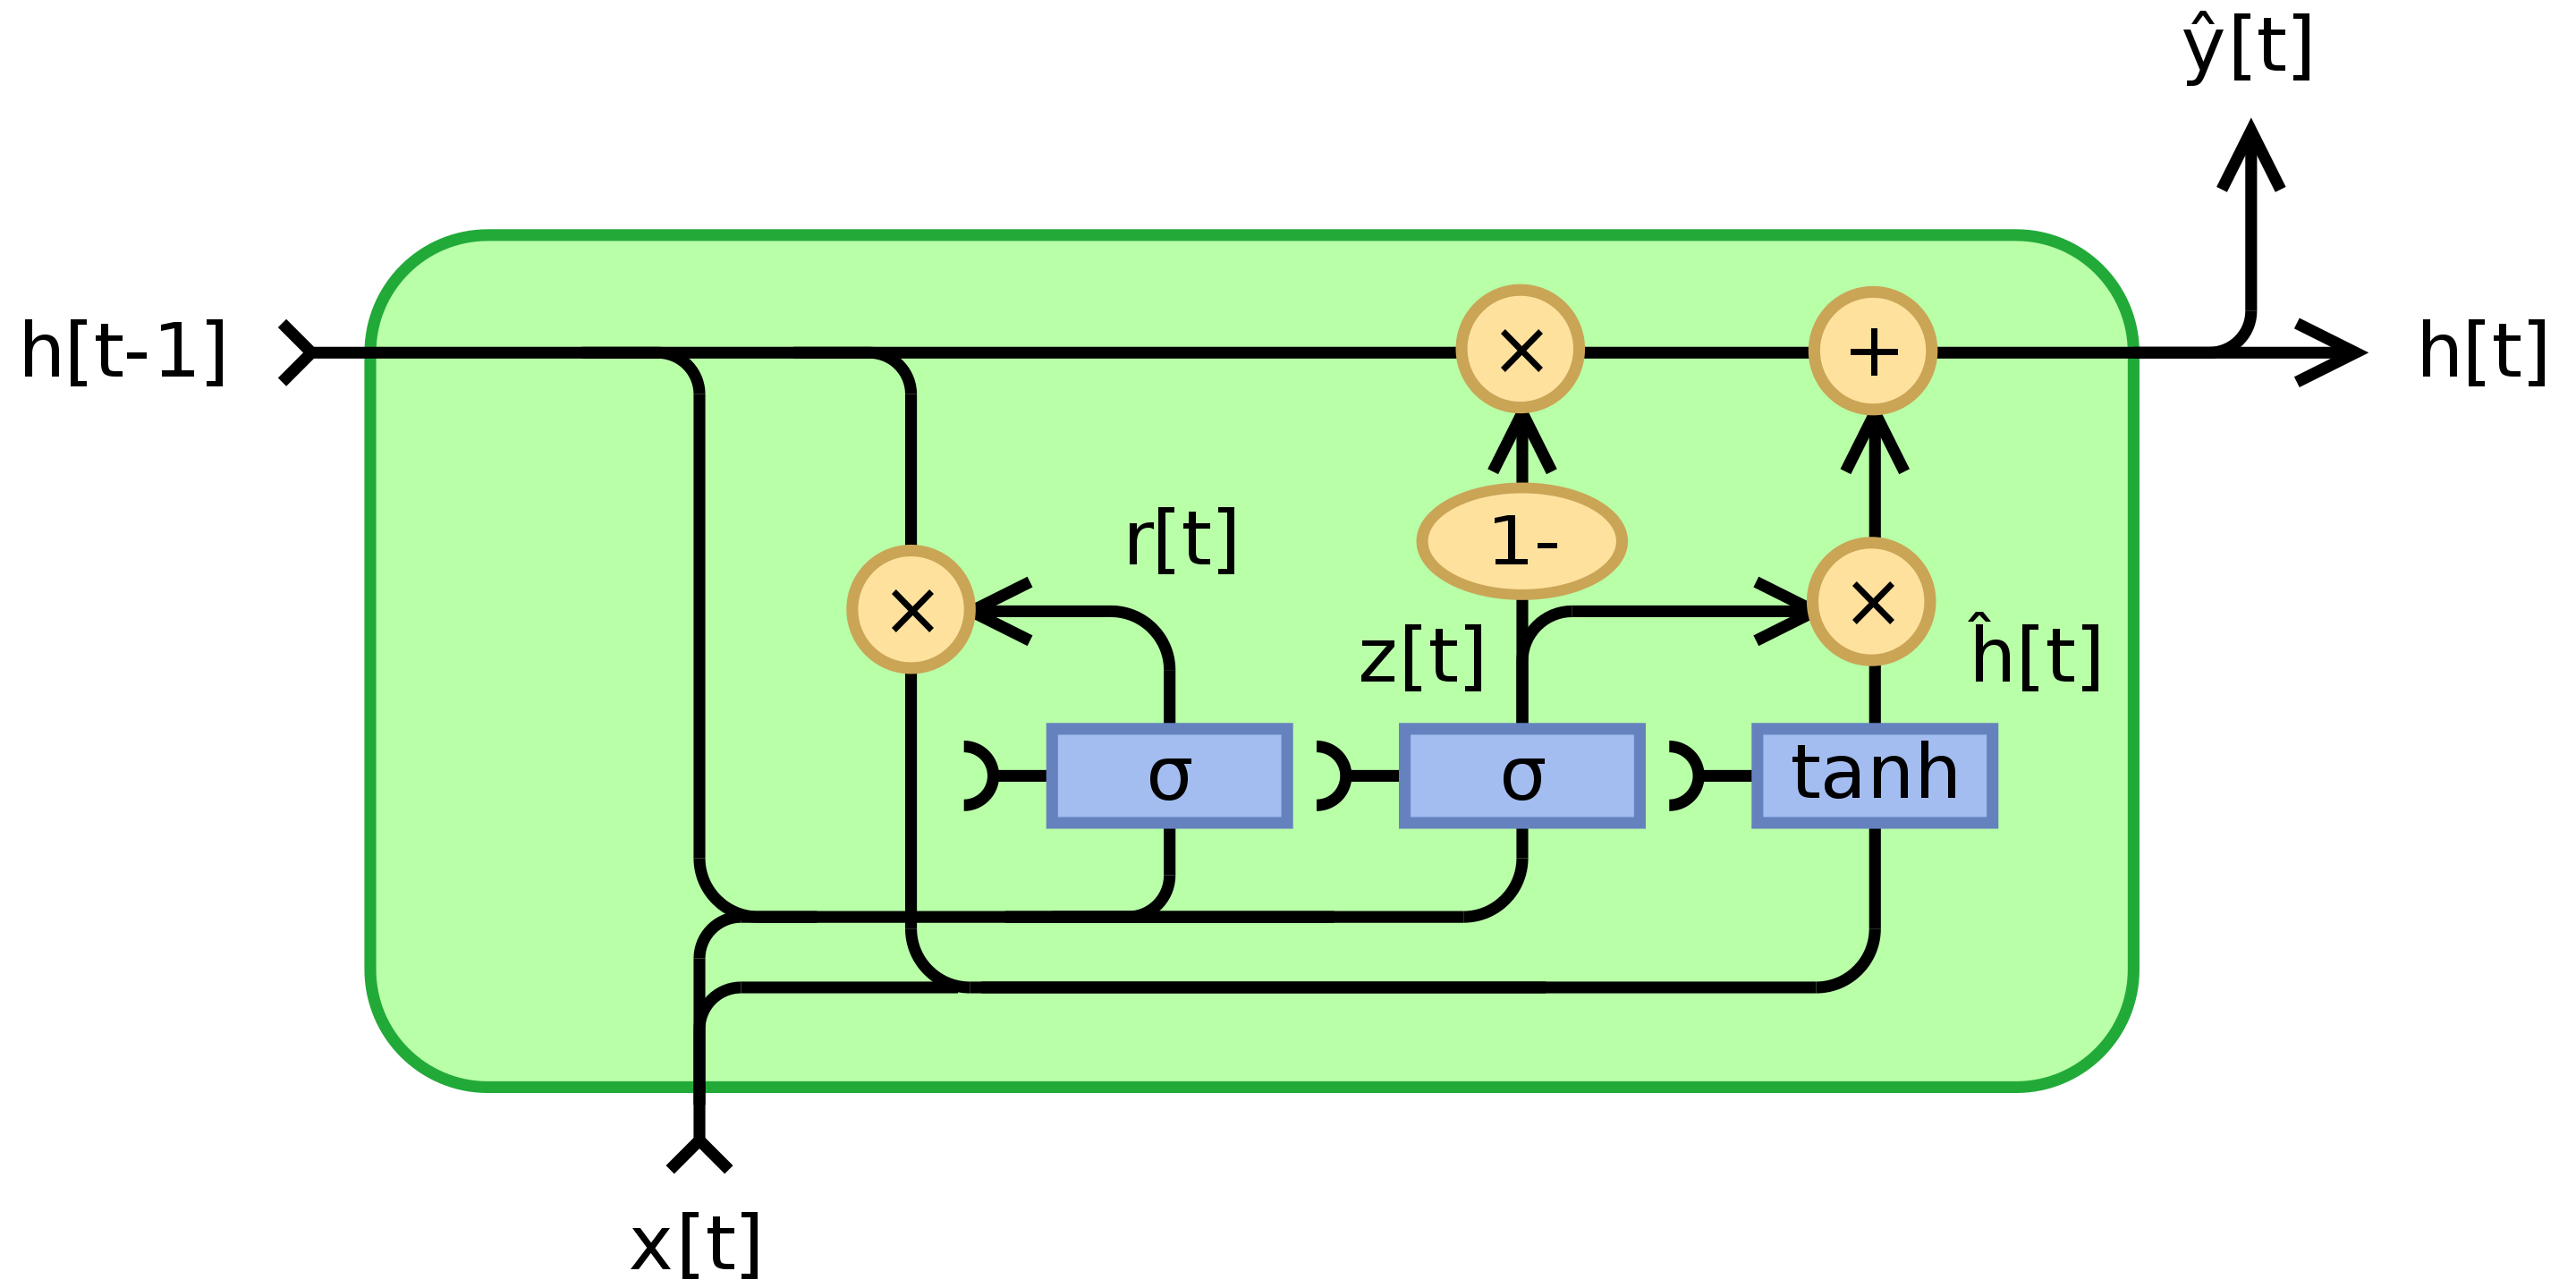

To learn more about GRU, please watch these short videos:

https://www.coursera.org/lecture/intro-to-deep-learning/modern-rnns-lstm-and-gru-WpduX

https://www.youtube.com/watch?v=pYRIOGTPRPU

Similar to the embedding layer, GRU module is not implemented in the Objax. The following is an implementation of the GRU cell in the Objax.

**Question 6[3 points]:** In the following implementation, complete the `__call__` function. 

In [ ]:
class GRU(objax.Module):
    def __init__(self, nin: int, nout: int,
                 init_w: Callable = objax.nn.init.xavier_truncated_normal,
                 init_b: Callable = objax.nn.init.truncated_normal):
        self.update_w = objax.TrainVar(init_w((nin, nout)))
        self.update_u = objax.TrainVar(init_w((nout, nout)))
        self.update_b = objax.TrainVar(init_b((nout,), stddev=0.01))
        self.reset_w = objax.TrainVar(init_w((nin, nout)))
        self.reset_u = objax.TrainVar(init_w((nout, nout)))
        self.reset_b = objax.TrainVar(init_b((nout,), stddev=0.01))
        self.output_w = objax.TrainVar(init_w((nin, nout)))
        self.output_u = objax.TrainVar(init_w((nout, nout)))
        self.output_b = objax.TrainVar(init_b((nout,), stddev=0.01))

    def __call__(self, x: JaxArray, initial_state: JaxArray) -> Tuple[JaxArray, JaxArray]:
        def scan_op(state: JaxArray, x: JaxArray) -> JaxArray:  # State must come first for lax.scan
            # fill this in
            update_gate = objax.functional.sigmoid(jn.dot(x, self.update_w.value) + jn.dot(state, self.update_u.value) + self.update_b.value)

            # fill this in
            reset_gate = objax.functional.sigmoid(jn.dot(x, self.reset_w.value) + jn.dot(state, self.reset_u.value) + self.reset_b.value)
            
            # fill this in
            output_gate = objax.functional.tanh(jn.dot(x, self.output_w.value) + jn.dot(reset_gate*state, self.output_u.value) + self.output_b.value)
            
            return update_gate * state + (1 - update_gate) * output_gate, 0  # we don't use the output, return 0.

        return lax.scan(scan_op, initial_state, x.transpose((1, 0, 2)))[0]

**Questions 7** (bonus)[5 points]: With an example, explain in detail what does lax.scan function do, and what it is useful for?

To use jit and avoid long run times of loops we will need to use jax.lax.scan to keep the loop rolled. The jax.lax.scan takes in a function, initial carry value, a sequence over which to scan along the leading axis. It returns the final carry value and the final output of the function after all iterations. For ex we have the following function (func_jax3) and we want to code it without using a loop, here scan will come into play. Scan for the above function can be implemented as shown below (func_jax4) – 
 
Here lax.scan will iterate over function body with the initial carry as 0 and some array x (np.array([1,2,5,6]) scan will iterate for all x in x, thus for 1st iteration c = 0 and x =  1 the return of the body is 1,1 for 2nd iteration c = 1 and x = 2 return is 3,3, for 3rd iteration c = 3 and x = 5 return is 8,8 for the final iteration c = 8 and x = 6 return is 14,14 if you sum up all the values of x we get the same output as of the function with for loop in it. Just for explanation it was said as if a loop is going on that is how scan keeps the loop rolled. It useful for reducing compilation times for jit-compiled functions, since native Python loop constructs in an @jit function are unrolled, leading to large XLA computations.[5]

[5] https://jax.readthedocs.io/en/latest/_autosummary/jax.lax.scan.html

In [ ]:
def func_jax3(x):
    t = len(x)
    f = 0.
    tot = 0.
    for i in range(t):
        f = f + x[i]
        tot = tot + f
    return tot

def func_jax4(x):
    def body(c, x_i):
        return c + x_i, c + x_i

    a, f = lax.scan(body, 0., x)
    return np.sum(f)

temp = np.array([1,2,5,6])

a = func_jax3(temp)
b = func_jax4(temp)

In [ ]:
a,b

(26.0, DeviceArray(26., dtype=float32))

# The classifier 

The structure of the proposed classifier is as follows:


*   The input is a vector whose elements are integers in the interval $\{$1,...,max_vocab$\}$ of length max_len. In fact input is the one-hot encoding of each review.
*    Then, the embedding layer converts this vector into a matrix of size (max_len,embedding_size).
* Then, we feed each row of this matrix into the GRU cell. The size of the output vector of the GRU is num_hidden_units_GRU.
*  The output of the GRU is feed into a fully-connected layer with num_hidden_units neurons and ReLU activation function.

* Finally, we have the output layer which is a fully-connected layer with two outputs corresponding to the positive or negative label.



**Question 8** [3 points]: implement the described classifier using `objax.nn.Sequential`.




In [ ]:
# fill this in:
gru_rnn = objax.nn.Sequential([Embed(max_len, embedding_size), GRU(embedding_size, num_hidden_units_GRU), objax.nn.Linear(num_hidden_units_GRU, num_hidden_units), 
                               objax.functional.relu, objax.nn.Linear(num_hidden_units, 2)
])

You can print the structure as well as the number of the parameters of the each layer using the following line of codes.

In [ ]:
print(f'{" Network ":-^79}')
print(gru_rnn.vars())

----------------------------------- Network -----------------------------------
(Sequential)[0](Embed).w          6000 (200, 30)
(Sequential)[1](GRU).update_w      900 (30, 30)
(Sequential)[1](GRU).update_u      900 (30, 30)
(Sequential)[1](GRU).update_b       30 (30,)
(Sequential)[1](GRU).reset_w       900 (30, 30)
(Sequential)[1](GRU).reset_u       900 (30, 30)
(Sequential)[1](GRU).reset_b        30 (30,)
(Sequential)[1](GRU).output_w      900 (30, 30)
(Sequential)[1](GRU).output_u      900 (30, 30)
(Sequential)[1](GRU).output_b       30 (30,)
(Sequential)[2](Linear).b           60 (60,)
(Sequential)[2](Linear).w         1800 (30, 60)
(Sequential)[4](Linear).b            2 (2,)
(Sequential)[4](Linear).w          120 (60, 2)
+Total(14)                       13472


**Question 9** [3 points]: Draw the classifier architecture diagram. For GRU consider drawing the unrolled version. You do not need to draw the internal structure of the GRU. 

**Question 10**[1 point]: Construct an SGD optimizer using objax optimizers package.

In [ ]:
## Your implementaiton of the optimizer should go here
opt = objax.optimizer.SGD(gru_rnn.vars())

Then, we define the loss function, training operation function, and the
evaluation function.

In [ ]:
def loss_function(x: JaxArray, y: JaxArray):
    logits = gru_rnn(x, initial_state=jn.zeros((x.shape[0], num_hidden_units_GRU)))
    return objax.functional.loss.cross_entropy_logits_sparse(logits, y).sum()


gv = objax.GradValues(loss_function, gru_rnn.vars())


@objax.Function.with_vars(gv.vars() + opt.vars())
def train_op(x: JaxArray, y: JaxArray, lr: float):
    g, loss = gv(x, y)
    opt(lr, g)
    return loss


train_op = objax.Jit(train_op)
eval_op = objax.Jit(lambda x: gru_rnn(x, initial_state=jn.zeros((x.shape[0], num_hidden_units_GRU))),
                    gru_rnn.vars())


The next function is a helper for computing the accuracy.

In [ ]:

def accuracy(data_loader):
    """Compute the accuracy for a provided data loader"""
    acc_total = 0
    x, y = data_loader
    batch_size_acc = 500
    for batch_idx in np.array_split(np.arange(len(x)), len(x) // batch_size_acc):
        x_batch, target_class = x[batch_idx], y[batch_idx]
        predicted_class = eval_op(x_batch).argmax(1)
        acc_total += (predicted_class == target_class).sum()
    return acc_total / len(x)

**Question 11** [4 points]: Write the training loop to train the model. In each epoch, record the training accuracy and the validation accuracy. Also, at the end of the training report the accuracy on the test set. Please use the training set to train the model, the validation set to monitor accuracy during training, and then the test set once after training is complete to measure the final generalization of the model.

In [ ]:
learning_rate = 1e-3 # learning rate
num_epochs = 20 # number of epochs
batch_size = 250  # batch size
training_data = (messages_train, labels_train)
validation_data = (messages_valid, labels_valid)
test_data = (messages_test, labels_test)

In [ ]:
# you code for the training loop should start here 
def train(num_epochs, batch_size, learning_rate, training_data, validation_data):
  avg_train_loss_epoch = []
  avg_val_loss_epoch = []
  train_acc_epoch = []
  val_acc_epoch = []

  for epoch in range(num_epochs):
      avg_train_loss = 0 # (averaged) training loss per batch
      avg_val_loss =  0  # (averaged) validation loss per batch
      train_acc = 0      # training accuracy per batch
      val_acc = 0        # validation accuracy per batch

      # shuffle the examples prior to training to remove correlation 
      train_indices = np.arange(len(training_data[0])) 
      np.random.shuffle(train_indices)
      for it in range(0, training_data[0].shape[0], batch_size):
          batch = train_indices[it:it+batch_size] 
          avg_train_loss += float(train_op(training_data[0][batch], training_data[1][batch], learning_rate)[0]) * len(batch)
      train_acc_epoch.append(accuracy(training_data))
      avg_train_loss_epoch.append(avg_train_loss/training_data[0].shape[0])

      # run validation
      val_indices = np.arange(len(validation_data[0])) 
      np.random.shuffle(val_indices)    
      for it in range(0, validation_data[0].shape[0], batch_size):
          batch = val_indices[it:it+batch_size] 
          avg_val_loss += float(loss_function(validation_data[0][batch], validation_data[1][batch])) * len(batch)
      val_acc_epoch.append(accuracy(validation_data))
      avg_val_loss_epoch.append(avg_val_loss/validation_data[0].shape[0])

      print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss_epoch[epoch], avg_val_loss_epoch[epoch], 100*train_acc_epoch[epoch], 100*val_acc_epoch[epoch]))

  # Printing the best validation accuracy with the epoch
  print('Best Validation Accuracy %.2f at %02d Epoch' % (100*max(val_acc_epoch), val_acc_epoch.index(max(val_acc_epoch))+1))

  return avg_train_loss_epoch, avg_val_loss_epoch, train_acc_epoch, val_acc_epoch

In [ ]:
avg_train_loss_epoch, avg_val_loss_epoch, train_acc_epoch, val_acc_epoch = train(num_epochs, batch_size, learning_rate, training_data, validation_data)

Epoch 0001  Training Loss 173.07 Validation Loss 172.57 Training Accuracy 52.65 Validation Accuracy 54.08
Epoch 0002  Training Loss 172.53 Validation Loss 171.74 Training Accuracy 54.62 Validation Accuracy 55.36
Epoch 0003  Training Loss 171.47 Validation Loss 170.04 Training Accuracy 56.81 Validation Accuracy 56.48
Epoch 0004  Training Loss 169.34 Validation Loss 166.92 Training Accuracy 59.35 Validation Accuracy 58.98
Epoch 0005  Training Loss 167.35 Validation Loss 162.78 Training Accuracy 62.74 Validation Accuracy 62.56
Epoch 0006  Training Loss 165.34 Validation Loss 161.62 Training Accuracy 61.71 Validation Accuracy 63.00
Epoch 0007  Training Loss 162.94 Validation Loss 157.94 Training Accuracy 64.98 Validation Accuracy 65.04
Epoch 0008  Training Loss 160.04 Validation Loss 152.92 Training Accuracy 67.37 Validation Accuracy 67.12
Epoch 0009  Training Loss 158.34 Validation Loss 149.92 Training Accuracy 68.19 Validation Accuracy 68.76
Epoch 0010  Training Loss 156.88 Validation Lo

In [ ]:
predicted = eval_op(test_data[0]).argmax(1)
acc_total = (predicted == test_data[1]).sum()
print('Testing Accuracy:', 100*acc_total/len(test_data[0]))

Testing Accuracy: 73.14001


The generalization of the model is quite good as the validation and test accuracy are quite close.

**Question 12:[1 points]**  Plot the training accuracy and the validation accuracy versus the number of epochs. What is the generalization gap between the test and training?

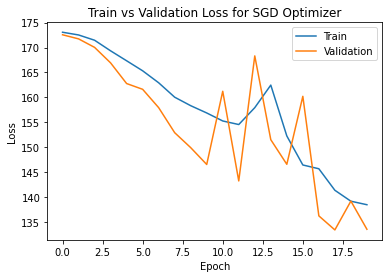

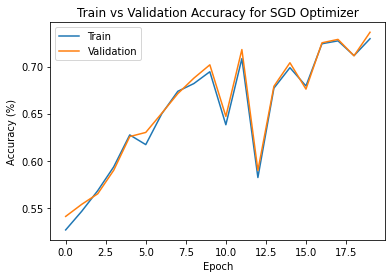

In [ ]:
#Plot for loss
plt.title("Train vs Validation Loss for SGD Optimizer")
plt.plot(avg_train_loss_epoch, label="Train")
plt.plot(avg_val_loss_epoch, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.show()

#Plot for accuracy
plt.title("Train vs Validation Accuracy for SGD Optimizer")
plt.plot(train_acc_epoch, label="Train")
plt.plot(val_acc_epoch, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend(loc='best')
plt.show()

There not much generalization gap between the train and validation accuracy. It might be the case that the model has not yet reached its optimum.

# Comparing SGD with Adam

**Question 13** [4 points]: Train the same model with the same parameters using the Adam optimizer instead of the SGD. Do not forgot to initialize the network before training, otherwise the previous model will continue training from the final model parameters rather than start from a fresh set of random weight initialization values.

In [ ]:
# Define (again) your model here
gru_rnn2 = objax.nn.Sequential([Embed(max_len, embedding_size), GRU(embedding_size, num_hidden_units_GRU), objax.nn.Linear(num_hidden_units_GRU, num_hidden_units), 
                               objax.functional.relu, objax.nn.Linear(num_hidden_units, 2)
])

In [ ]:
## Your implementaiton of the optimizer should go here
opt2 = objax.optimizer.Adam(gru_rnn2.vars())

You will also need the following functions.

In [ ]:
def loss_function(x: JaxArray, y: JaxArray):
    logits = gru_rnn2(x, initial_state=jn.zeros((x.shape[0], num_hidden_units_GRU)))
    return objax.functional.loss.cross_entropy_logits_sparse(logits, y).sum()


gv2 = objax.GradValues(loss_function, gru_rnn2.vars())


@objax.Function.with_vars(gv2.vars() + opt2.vars())
def train_op(x: JaxArray, y: JaxArray, lr: float):
    g, loss = gv2(x, y)
    opt2(lr, g)
    return loss


train_op = objax.Jit(train_op)
eval_op = objax.Jit(lambda x: gru_rnn2(x, initial_state=jn.zeros((x.shape[0], num_hidden_units_GRU))),
                    gru_rnn2.vars())

In [ ]:
learning_rate = 1e-3
num_epochs = 20
batch_size = 250 
training_data = (messages_train, labels_train)
validation_data = (messages_valid, labels_valid)
test_data = (messages_test, labels_test)


In [ ]:
# you code for the training loop should start here 
def train2(num_epochs, batch_size, learning_rate, training_data, validation_data):
  avg_train_loss_epoch = []
  avg_val_loss_epoch = []
  train_acc_epoch = []
  val_acc_epoch = []

  for epoch in range(num_epochs):
      avg_train_loss = 0 # (averaged) training loss per batch
      avg_val_loss =  0  # (averaged) validation loss per batch
      train_acc = 0      # training accuracy per batch
      val_acc = 0        # validation accuracy per batch

      # shuffle the examples prior to training to remove correlation 
      train_indices = np.arange(len(training_data[0])) 
      np.random.shuffle(train_indices)
      for it in range(0, training_data[0].shape[0], batch_size):
          batch = train_indices[it:it+batch_size] 
          avg_train_loss += float(train_op(training_data[0][batch], training_data[1][batch], learning_rate)[0]) * len(batch)
      train_acc_epoch.append(accuracy(training_data))
      avg_train_loss_epoch.append(avg_train_loss/training_data[0].shape[0])

      # run validation
      val_indices = np.arange(len(validation_data[0])) 
      np.random.shuffle(val_indices)    
      for it in range(0, validation_data[0].shape[0], batch_size):
          batch = val_indices[it:it+batch_size] 
          avg_val_loss += float(loss_function(validation_data[0][batch], validation_data[1][batch])) * len(batch)
      val_acc_epoch.append(accuracy(validation_data))
      avg_val_loss_epoch.append(avg_val_loss/validation_data[0].shape[0])

      print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss_epoch[epoch], avg_val_loss_epoch[epoch], 100*train_acc_epoch[epoch], 100*val_acc_epoch[epoch]))

  # Printing the best validation accuracy with the epoch
  print('Best Validation Accuracy %.2f for Adam Optimizer at %02d Epoch' % (100*max(val_acc_epoch), val_acc_epoch.index(max(val_acc_epoch))+1))

  return avg_train_loss_epoch, avg_val_loss_epoch, train_acc_epoch, val_acc_epoch

In [ ]:
avg_train_loss_epoch1, avg_val_loss_epoch1, train_acc_epoch1, val_acc_epoch1 = train2(num_epochs, batch_size, learning_rate, training_data, validation_data)

Epoch 0001  Training Loss 155.12 Validation Loss 132.16 Training Accuracy 73.69 Validation Accuracy 74.00
Epoch 0002  Training Loss 128.93 Validation Loss 123.57 Training Accuracy 75.65 Validation Accuracy 76.66
Epoch 0003  Training Loss 128.53 Validation Loss 123.70 Training Accuracy 75.77 Validation Accuracy 76.22
Epoch 0004  Training Loss 129.52 Validation Loss 124.83 Training Accuracy 75.06 Validation Accuracy 75.74
Epoch 0005  Training Loss 128.71 Validation Loss 129.97 Training Accuracy 73.97 Validation Accuracy 73.84
Epoch 0006  Training Loss 130.98 Validation Loss 130.67 Training Accuracy 73.22 Validation Accuracy 73.52
Epoch 0007  Training Loss 131.86 Validation Loss 125.25 Training Accuracy 74.73 Validation Accuracy 75.44
Epoch 0008  Training Loss 125.55 Validation Loss 122.40 Training Accuracy 76.04 Validation Accuracy 76.56
Epoch 0009  Training Loss 125.97 Validation Loss 122.23 Training Accuracy 76.18 Validation Accuracy 76.04
Epoch 0010  Training Loss 122.69 Validation Lo

In [ ]:
predicted = eval_op(test_data[0]).argmax(1)
acc_total = (predicted == test_data[1]).sum()
print('Testing Accuracy for Adam Optimizer:', 100*acc_total/len(test_data[0]))

Testing Accuracy for Adam Optimizer: 79.08


The generalization of the model is quite good as the validation and test accuracy are quite close. In fact, the Adam optimizer performs better than the SGD optimizer.

**Question 14** [1 points]: Plot the training accuracy and validation accuracy versus the epochs, and compare your results with the case that you trained the network using SGD. What is the generalization gap for this case?

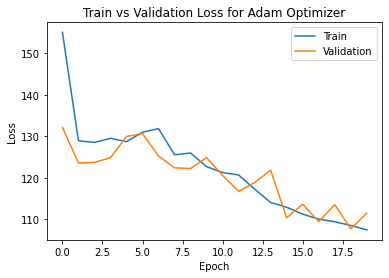

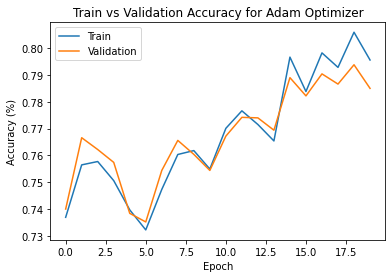

In [ ]:
#Plot for loss
plt.title("Train vs Validation Loss for Adam Optimizer")
plt.plot(avg_train_loss_epoch1, label="Train")
plt.plot(avg_val_loss_epoch1, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.show()

#Plot for accuracy
plt.title("Train vs Validation Accuracy for Adam Optimizer")
plt.plot(train_acc_epoch1, label="Train")
plt.plot(val_acc_epoch1, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend(loc='best')
plt.show()

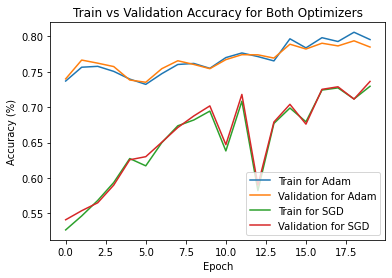

In [ ]:
plt.title("Train vs Validation Accuracy for Both Optimizers")
plt.plot(train_acc_epoch1, label="Train for Adam")
plt.plot(val_acc_epoch1, label="Validation for Adam")
plt.plot(train_acc_epoch, label="Train for SGD")
plt.plot(val_acc_epoch, label="Validation for SGD")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend(loc='best')
plt.show()

**Questions 15** [1 points]: Briefly explain how Adam optimizer works and compare it with the SGD optimizaer.

Adam uses second order optimization which tells us about the curvature of the loss function to get out of regions (plateau, ravine etc.). Adam uses a little bit of curvature information and is practical for neural networks. The equation used in Adam optimizer is shown below – 

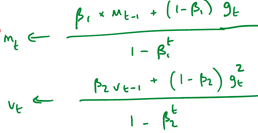

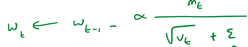

m is the first order moment of the gradient (mean), g is the gradient, and v is the second order moment of the gradient (variance). We are calculating the exponential moving average of the gradients and slowly forgetting about them in the m and v equation (the previous gradients are getting multiplied with a number less than zero every time thus, its effects diminish). We will use m and v to control how quickly we update the model weights. v adjusts the weights for each of the weights based on the variance of gradients for that weight. When the variance is high the learning will decelerate and when the variance is low then the learning will accelerate. Here the updates for each of the weights will depend on the gradient and the moving averages for that weight. 
SGD only takes 1st order derivatives of the loss function. Adam gives good results without too much tuning of the learning rate (as it is automatically updated through variance) but the learning rate of SGD need to be tuned properly and finely tuned learning rate for SGD performs as best as untuned Adam optimizer.

# Early Stopping

**Questions 16** [3 points]: 
This time implement the early stopping method with a patience window. All the parameters are the same as the previous section. Also, set the patience window to 5 epochs.

In [ ]:
# Your implementation of the model should go here
gru_rnn3 = objax.nn.Sequential([Embed(max_len, embedding_size), GRU(embedding_size, num_hidden_units_GRU), objax.nn.Linear(num_hidden_units_GRU, num_hidden_units), 
                               objax.functional.relu, objax.nn.Linear(num_hidden_units, 2)
])

In [ ]:
## Your implementaiton of the optimizer should go here
opt3 = objax.optimizer.Adam(gru_rnn3.vars())

You will also need the following functions.

In [ ]:
def loss_function(x: JaxArray, y: JaxArray):
    logits = gru_rnn3(x, initial_state=jn.zeros((x.shape[0], num_hidden_units_GRU)))
    return objax.functional.loss.cross_entropy_logits_sparse(logits, y).sum()


gv3 = objax.GradValues(loss_function, gru_rnn3.vars())


@objax.Function.with_vars(gv3.vars() + opt3.vars())
def train_op(x: JaxArray, y: JaxArray, lr: float):
    g, loss = gv3(x, y)
    opt3(lr, g)
    return loss


train_op = objax.Jit(train_op)
eval_op = objax.Jit(lambda x: gru_rnn3(x, initial_state=jn.zeros((x.shape[0], num_hidden_units_GRU))),
                    gru_rnn3.vars())

In [ ]:
learning_rate = 1e-3
num_epochs = 20
batch_size = 250 
max_patience_window = 5
training_data = (messages_train, labels_train)
validation_data = (messages_valid, labels_valid)
test_data = (messages_test, labels_test)

In [ ]:
# you code for the training loop should start here  
def train3(num_epochs, batch_size, learning_rate, training_data, validation_data, max_patience_window):
  avg_train_loss_epoch = []
  avg_val_loss_epoch = []
  train_acc_epoch = []
  val_acc_epoch = []
  models = [] #To store the model with minimum loss
  counter = 0

  for epoch in range(num_epochs):
      avg_train_loss = 0 # (averaged) training loss per batch
      avg_val_loss =  0  # (averaged) validation loss per batch
      train_acc = 0      # training accuracy per batch
      val_acc = 0        # validation accuracy per batch

      # shuffle the examples prior to training to remove correlation 
      train_indices = np.arange(len(training_data[0])) 
      np.random.shuffle(train_indices)
      for it in range(0, training_data[0].shape[0], batch_size):
          batch = train_indices[it:it+batch_size] 
          avg_train_loss += float(train_op(training_data[0][batch], training_data[1][batch], learning_rate)[0]) * len(batch)
      train_acc_epoch.append(accuracy(training_data))
      avg_train_loss_epoch.append(avg_train_loss/training_data[0].shape[0])

      # run validation
      val_indices = np.arange(len(validation_data[0])) 
      np.random.shuffle(val_indices)    
      for it in range(0, validation_data[0].shape[0], batch_size):
          batch = val_indices[it:it+batch_size] 
          avg_val_loss += float(loss_function(validation_data[0][batch], validation_data[1][batch])) * len(batch)
      val_acc_epoch.append(accuracy(validation_data))
      avg_val_loss_epoch.append(avg_val_loss/validation_data[0].shape[0])

      #If the minimum of validation loss in all epochs is equal to the loss of this epoch then set counter = 0 and store the model
      if avg_val_loss_epoch[epoch] == min(avg_val_loss_epoch):
        counter = 0
        # https://objax.readthedocs.io/en/latest/advanced/io.html#saving-and-loading-model-weights
        models.append(pickle.dump(gru_rnn3, open('gru_rnn3.pickle', 'wb')))
        
      #If the minimum of validation loss in all epochs is not equal to the loss of this epoch then increment the counter
      else:
        counter += 1

      print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss_epoch[epoch], avg_val_loss_epoch[epoch], 100*train_acc_epoch[epoch], 100*val_acc_epoch[epoch]))

      #If the counter reaches the patience window then break out of the loop and return the best model parameters stored while setting counter to 0
      if counter == max_patience_window:
        return avg_train_loss_epoch, avg_val_loss_epoch, train_acc_epoch, val_acc_epoch, models[-1]
        break      

  return avg_train_loss_epoch, avg_val_loss_epoch, train_acc_epoch, val_acc_epoch, models[-1]

In [ ]:
avg_train_loss_epoch, avg_val_loss_epoch, train_acc_epoch, val_acc_epoch, models = train3(num_epochs, batch_size, learning_rate, training_data, validation_data, max_patience_window)

Epoch 0001  Training Loss 155.86 Validation Loss 135.65 Training Accuracy 72.85 Validation Accuracy 74.04
Epoch 0002  Training Loss 129.98 Validation Loss 128.02 Training Accuracy 74.49 Validation Accuracy 74.80
Epoch 0003  Training Loss 129.02 Validation Loss 130.32 Training Accuracy 73.55 Validation Accuracy 74.58
Epoch 0004  Training Loss 133.44 Validation Loss 129.23 Training Accuracy 74.08 Validation Accuracy 74.40
Epoch 0005  Training Loss 131.20 Validation Loss 128.06 Training Accuracy 74.32 Validation Accuracy 74.84
Epoch 0006  Training Loss 129.96 Validation Loss 129.61 Training Accuracy 73.77 Validation Accuracy 74.06
Epoch 0007  Training Loss 127.58 Validation Loss 123.51 Training Accuracy 75.46 Validation Accuracy 76.00
Epoch 0008  Training Loss 125.27 Validation Loss 122.56 Training Accuracy 75.90 Validation Accuracy 76.66
Epoch 0009  Training Loss 122.56 Validation Loss 119.28 Training Accuracy 76.76 Validation Accuracy 77.04
Epoch 0010  Training Loss 120.64 Validation Lo

**Question 16**[1 points]: Report the best validation accuracy and the test accuracy of your best model.

In [ ]:
# Printing the best validation accuracy with the epoch
print('Best Validation Accuracy %.2f ' % (100*max(val_acc_epoch)))

#Unpack the model obatined from the training run
# https://objax.readthedocs.io/en/latest/advanced/io.html#saving-and-loading-model-weights
model = pickle.load(open('gru_rnn3.pickle', 'rb'))
eval_op = objax.Jit(lambda x: model(x, initial_state=jn.zeros((x.shape[0], num_hidden_units_GRU))),
                    model.vars())
predicted = eval_op(test_data[0]).argmax(1)
acc_total = (predicted == test_data[1]).sum()
print('Testing Accuracy for best model:', 100*acc_total/len(test_data[0]))

Best Validation Accuracy 79.80 
Testing Accuracy for best model: 79.840004
